# Analyse ROMY Events - Tilt Correction - One Day

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
# import multitaper

from obspy.clients.fdsn import Client
from twistpy.tilt.correction import remove_tilt

In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [12]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## Event
config['event_name'] = "Wind"
config['tbeg'] = obs.UTCDateTime("2024-03-21 00:00")
config['tend'] = obs.UTCDateTime("2024-03-22 00:00")
config['trim'] = [9*3600, 0]

## Noise
# config['event_name'] = "Noise"
# config['tbeg'] = obs.UTCDateTime("2024-03-29 00:00")
# config['tend'] = obs.UTCDateTime("2024-03-30 00:00")
# config['trim'] = [15*3600, 4*3600]



config['filename'] = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['Client'] = Client("USGS")

## ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941



## Load Data

In [8]:
# config, dist, baz, az = __get_event_info(config)

In [13]:
st0 = obs.read(config['path_to_data']+config['filename'])

st0 = st0.trim(config['tbeg']+config['trim'][0], config['tend']-config['trim'][1])


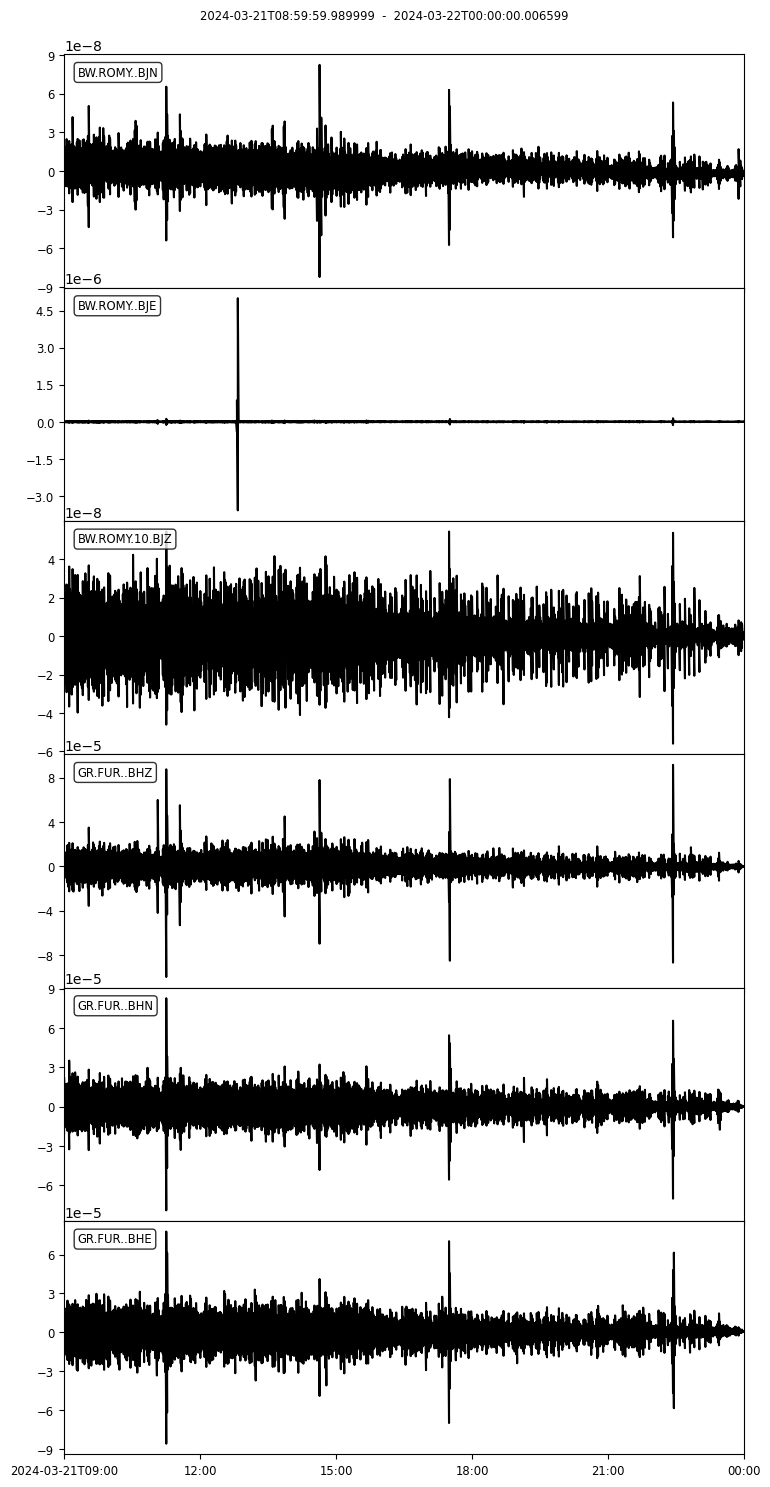

In [14]:
st0.plot(equal_scale=False);

In [15]:
st0

6 Trace(s) in Stream:
BW.ROMY..BJN   | 2024-03-21T09:00:00.006599Z - 2024-03-22T00:00:00.006599Z | 20.0 Hz, 1080001 samples
BW.ROMY..BJE   | 2024-03-21T08:59:59.997799Z - 2024-03-21T23:59:59.997799Z | 20.0 Hz, 1080001 samples
BW.ROMY.10.BJZ | 2024-03-21T09:00:00.004199Z - 2024-03-22T00:00:00.004199Z | 20.0 Hz, 1080001 samples
GR.FUR..BHE    | 2024-03-21T08:59:59.989999Z - 2024-03-21T23:59:59.989999Z | 20.0 Hz, 1080001 samples
GR.FUR..BHN    | 2024-03-21T08:59:59.990000Z - 2024-03-21T23:59:59.990000Z | 20.0 Hz, 1080001 samples
GR.FUR..BHZ    | 2024-03-21T08:59:59.990000Z - 2024-03-21T23:59:59.990000Z | 20.0 Hz, 1080001 samples

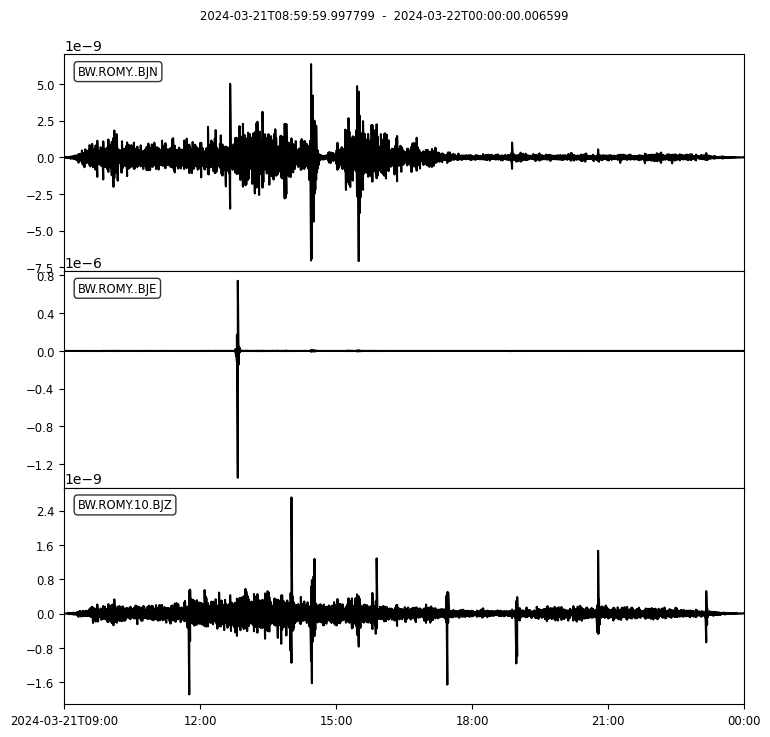

In [16]:
# fmin, fmax = 0.001, 0.01
fmin, fmax = 0.01, 0.1

rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station="FUR*", channel="*H*").copy()

rot1 = rot1.detrend("linear").taper(0.1, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.1, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

til1 = rot1.integrate()

# rot1 = rot1.detrend("demean")

til1.plot(equal_scale=False);

In [ ]:
_acc = acc1.copy().select(channel="*E")[0].data
_til = til1.copy().select(channel="*N")[0].data * 9.81 *10

plt.figure(figsize=(15, 5))
plt.plot(_acc)
plt.plot(_til)

NameError: name 'accNf' is not defined

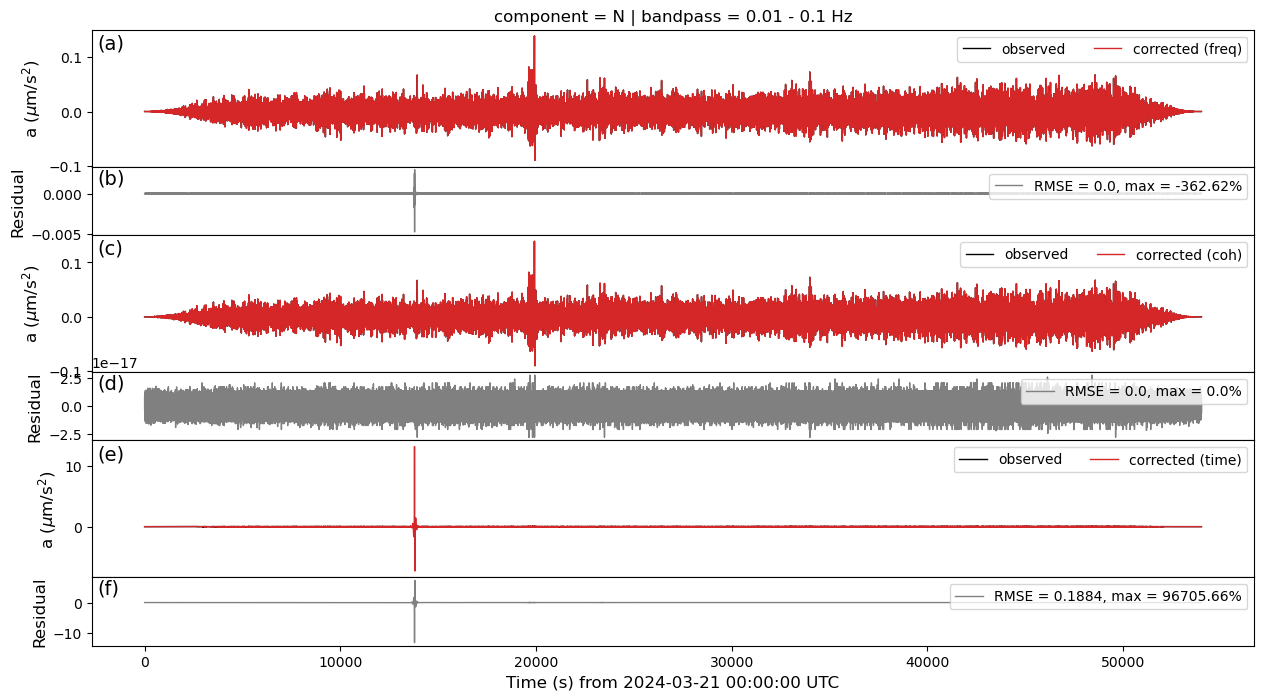

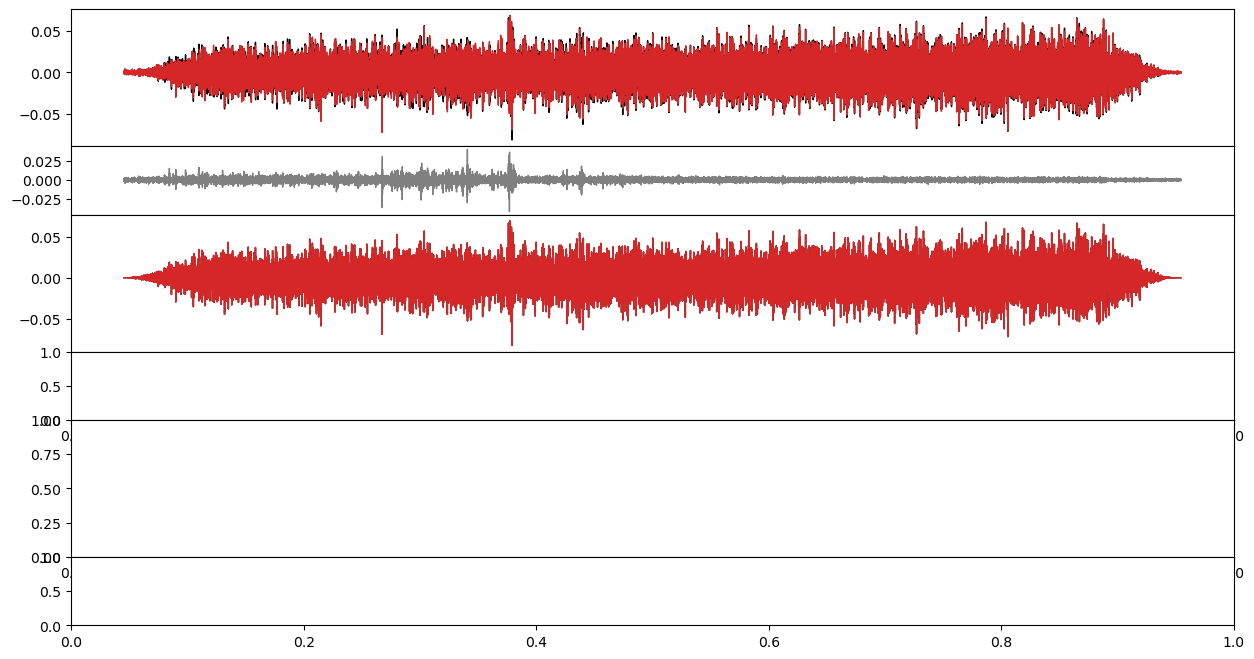

In [18]:
def __makeplot(til_in, acc_in, comp="N"):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat1-dat2)), np.amax(abs(dat1-dat2))
        pmax = round(vmax/dat1[imax]*100, 2)
        return pmax

    def __remove_tilt(acc0, rot0, m="freq", scale=1):

        dt = acc0[0].stats.delta

        accN_cor = remove_tilt(acc0.select(channel="*N")[0].data,
                               rot0.select(channel="*E")[0].data,
                               dt,
                               fmin,
                               fmax,
                               parallel=True,
                               # smooth=100.0 / 164.0,
                               method=m,
                               threshold=0.5 # only for coh
                              )

        accE_cor = remove_tilt(acc0.select(channel="*E")[0].data,
                               rot0.select(channel="*N")[0].data,
                               dt,
                               fmin,
                               fmax,
                               parallel=True,
                               # smooth=100.0 / 164.0,
                               method=m,
                               threshold=0.5 # only for coh
                               )

        return accE_cor*scale, accN_cor*scale

    acc = acc_in.copy()
    til = til_in.copy()

    times = acc.select(channel="*N")[0].times()

    Ncol, Nrow = 1, 9

    font = 12

    lw = 1

    scale, unit = 1e6, f"$\mu$m/s$^2$"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs[6:8, :])
    ax6 = fig.add_subplot(gs[8, :])

    accN = acc.select(channel="*N")[0].data*scale
    accE = acc.select(channel="*E")[0].data*scale

    # accN = __integrate(acc.copy(), accN)
    # accE = __integrate(acc.copy(), accE)

    accE_f, accN_f = __remove_tilt(acc.copy(), til.copy(), m="freq", scale=scale)
    accE_c, accN_c = __remove_tilt(acc.copy(), til.copy(), m="coh", scale=scale)
    accE_t, accN_t = __remove_tilt(acc.copy(), til.copy(), m="direct", scale=scale)

    # accE_f, accN_f = __integrate(acc.copy(), accE_f), __integrate(acc.copy(), accN_f)
    # accE_c, accN_c = __integrate(acc.copy(), accE_c), __integrate(acc.copy(), accN_c)
    # accE_t, accN_t = __integrate(acc.copy(), accE_t), __integrate(acc.copy(), accN_t)


    if comp == "N":
        ax1.plot(times, accN, color="k", label="observed", lw=lw)
        ax1.plot(times, accN_f, color="tab:red", label="corrected (freq)", lw=lw)

        ax2.plot(times, (accN-accN_f), color="grey", label=f"RMSE = {__rmse(accN, accN_f)}, max = {__get_residual_percent(accN, accN_f)}%", lw=lw)

        ax3.plot(times, accN, color="k", label="observed", lw=lw)
        ax3.plot(times, accN_c, color="tab:red", label="corrected (coh)", lw=lw)

        ax4.plot(times, (accN-accN_c), color="grey", label=f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%", lw=lw)

        ax5.plot(times, accN, color="k", label="observed", lw=lw)
        ax5.plot(times, accN_t, color="tab:red", label="corrected (time)", lw=lw)

        ax6.plot(times, (accN-accN_t), color="grey", label=f"RMSE = {__rmse(accN, accN_t)}, max = {__get_residual_percent(accN, accN_t)}%", lw=lw)

    elif comp == "E":
        ax1.plot(times, accE, color="k", label="observed", lw=lw)
        ax1.plot(times, accE_f, color="tab:red", label="corrected (freq)", lw=lw)

        imax, vmax = np.argmax(abs(accE-accE_f)), np.amax(abs(accE-accE_f))
        ax2.plot(times, (accE-accE_f), color="grey", label=f"RMSE = {__rmse(accE, accE_f)}, max = {round(vmax/accE[imax]*100, 2)}%", lw=lw)

        ax3.plot(times, accE, color="k", label="observed", lw=lw)
        ax3.plot(times, accE_c, color="tab:red", label="corrected (coh)", lw=lw)

        imax, vmax = np.argmax(abs(accE-accE_c)), np.amax(abs(accE-accE_c))
        ax4.plot(times, (accE-accE_c), color="grey", label=f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accN, accNf)}%", lw=lw)

        ax5.plot(times, accE, color="k", label="observed", lw=lw)
        ax5.plot(times, accE_t, color="tab:red", label="corrected (time)", lw=lw)

        imax, vmax = np.argmax(abs(accE-accE_t)), np.amax(abs(accE-accE_t))
        ax6.plot(times, (accE-accE_t), color="grey", label=f"RMSE = {__rmse(accE, accE_t)}, max = {round(vmax/accE[imax]*100, 2)}%", lw=lw)

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"a ({unit})", fontsize=font)
    ax3.set_ylabel(f"a ({unit})", fontsize=font)
    ax5.set_ylabel(f"a ({unit})", fontsize=font)

    ax2.set_ylabel(f"Residual", fontsize=font)
    ax4.set_ylabel(f"Residual", fontsize=font)
    ax6.set_ylabel(f"Residual", fontsize=font)

    # ax1.axis('off')
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.get_xaxis().set_visible(False)

#     ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
#     ax4.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax6.set_xlabel(f"Time (s) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)

    ax1.set_title(f"component = {comp} | bandpass = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot(til1, acc1, comp="N")

fig = __makeplot(til1, acc1, comp="E")


In [12]:
# dt = acc1[0].stats.delta

# accN_cor = remove_tilt(acc1.select(channel="*N")[0].data,
#                        til1.select(channel="*E")[0].data,
#                        dt,
#                        fmin,
#                        fmax,
#                        parallel=True,
# #                        smooth=100.0 / 164.0,
#                        method="freq",
#                       )

# accE_cor = remove_tilt(acc1.select(channel="*E")[0].data,
#                        til1.select(channel="*N")[0].data,
#                        dt,
#                        fmin,
#                        fmax,
#                        parallel=True,
# #                        smooth=100.0 / 164.0,
#                        method="freq",
#                        )